Lecturer: Prof. Dr. Philipp Berens

Tutors: Jonas Beck, Fabio Seel, Rita González Márquez

Summer term 2024

Name: Stephan Amann, Hannah Blaurock, David Kleindiek

# Neural Data Science Project 02

## Working with Calcium data

In the following project you will recieve a data set, along with a set of questions. Use the methods that you have learned throughout this course to explore the data and to answer the questions. You are free to use tools, resources and libraries as you see fit. Use comments and markdown cells to document your thought process and to explain your reasoning. We encourage you to compare different algorithms or to implement state of the art solutions. The notebook should be self contained, although you may offload some functions to a `utils.py`. The notebook should be concluded with a final summary / conclusions section.

## Question

**Is there spatial structure in the preferred orientation/direction/spatial frequency?**

Implement all steps of the processing pipeline that are necessary to answer them. Think of: 
1. Pre-processing 
2. Spike inference 
3. Tuning function fitting 
4. Statistical testing. 

It is sufficient to assess spatial structure visually. Bonus points for proper statistical assessment. Also bonus points if you focus on specific cell types.

## Please Read Me!

In our analysis we used `ipywidgets` interactive plots for the data exploration. We kept them here in this notebook, so that you can enjoy an interactive exploration, too. Initially the plots are set to the settings depicted in the pdf version of this notebook. Unfortunately, to see the plots **you must run the notebook** once. As the data processing and statistics computation take a while, we provide saved data you can use instead. The boolean flag `from_file` in the code cell below is already set to true. If you have a well performing machine, feel free to compute the data yourself - this takes at least 5 minutes. 

To be sure to have all packages installed, you can use our `requirements.txt` to fulfill the dependencies executing this command in a virtual environment (or any similar way you prefer).
```
pip install -r "requirements.txt"
```

Please use **>= Python 3.10**.

In [ ]:
# import packages here
import utils
from visualization import Visualization as VIS
from ipywidgets import interact, fixed, widgets
from IPython.display import display, Image, clear_output

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import jupyter_black

jupyter_black.load()

# if you want to process the data from scratch, set this to False. This takes at least 5 minutes to run the notebook, depending on your machine.
from_file = True

## Context
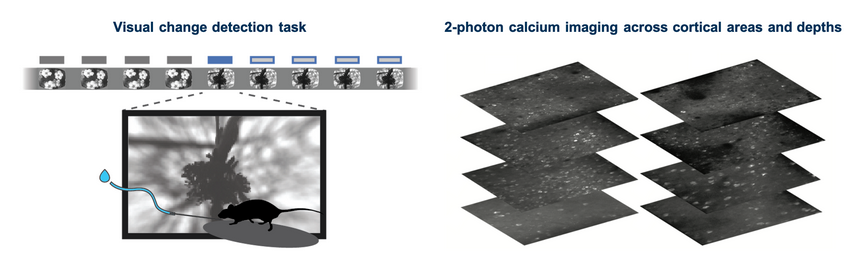

The data set that goes along with this notebook was recorded using in vivo 2-photon calcium imaging to measure the activity of genetically identified neurons in the visual cortex of mice performing a go/no-go visual change detection task. The data recordings stem from primary visual cortex and a GCaMP6f indicator was used. The data was recorded as follows.

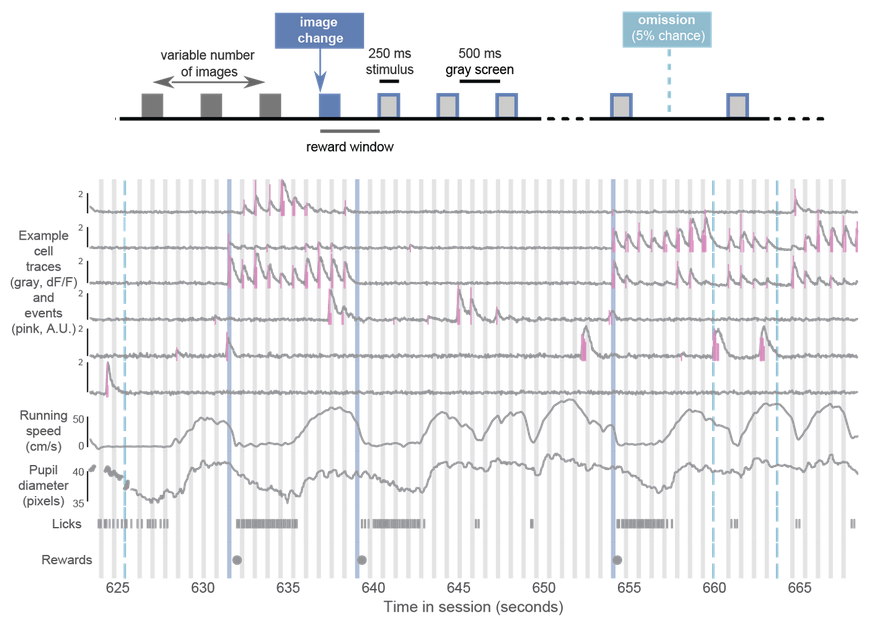

The data consists of:
- the preprocessed activity traces (df/f)
- the stimulus metadata
- the ROI masks for each cell
- a maximum activity projection of all ROIs
- running speed
- table of stimulus epochs

You will only work with a drifting grating stimulus.

Since the experiments were performed in sequence the calcium recordings that you receive also contain some other stimulus modalities (see `data["stim_epoch_table"]`). You can ignore these sections of the time-series data during analysis. Not all the data provided has to be used, however it can be incorporated into your analysis.

In [ ]:
# load data
def load_data(path="../data"):
    def array2df(d, key, cols):
        d[key] = pd.DataFrame(d[key], columns=cols)

    data = np.load(path + "/dff_data_dsi.npz", allow_pickle=True)
    data = dict(data)
    print("Data keys: ", data.keys())
    array2df(
        data,
        "stim_table",
        ["temporal_frequency", "orientation", "blank_sweep", "start", "end"],
    )
    array2df(data, "stim_epoch_table", ["stimulus", "start", "end"])

    return data


def print_info(data):
    data_iter = ((k, type(v), v.shape) for k, v in data.items())
    l = [f"[{k}] - {t}, - {s}" for k, t, s in data_iter]
    print("\n".join(l) + "\n")


data = load_data()

print("Overview of the data")
print_info(data)

Data keys:  dict_keys(['t', 'dff', 'stim_table', 'roi_masks', 'max_projection', 'running_speed', 'stim_epoch_table'])
Overview of the data
[t] - <class 'numpy.ndarray'>, - (115471,)
[dff] - <class 'numpy.ndarray'>, - (106, 115471)
[stim_table] - <class 'pandas.core.frame.DataFrame'>, - (628, 5)
[roi_masks] - <class 'numpy.ndarray'>, - (106, 512, 512)
[max_projection] - <class 'numpy.ndarray'>, - (512, 512)
[running_speed] - <class 'numpy.ndarray'>, - (2, 115471)
[stim_epoch_table] - <class 'pandas.core.frame.DataFrame'>, - (7, 3)



## 1. Exploratory Data Analysis

First we want to take a closer look at the data provided, to understand the experiment conducted. 

In [ ]:
# for visualization we use our self-written vis class to avoid clutter in this notebook.
# The data is passed to the class and assigned to variables like in this cell.
vis = VIS(data)

# assign data to variables for easier access
t = data["t"]
dff = data["dff"]
stim_table = data["stim_table"]
roi_masks = data["roi_masks"]
max_projection = data["max_projection"]
running_speed = np.nan_to_num(data["running_speed"][0], nan=0)
stim_epoch_table = data["stim_epoch_table"]

# change stim_table "start" and "end" to int for easier indexing
stim_table["start"] = stim_table["start"].astype(int)
stim_table["end"] = stim_table["end"].astype(int)

# mean time difference in t
t_diff = np.mean(np.diff(t))
print(f"Mean time difference in t: {t_diff} s with sd: {np.std(np.diff(t))} s")

fs = 1 / t_diff  # sampling frequency
dt = 1 / fs  # time step

print(f"Sampling frequency is {fs} Hz, Time Interval is {dt} s")

Mean time difference in t: 0.03325489373863341 s with sd: 4.998870724556607e-06 s
Sampling frequency is 30.070762151865303 Hz, Time Interval is 0.03325489373863341 s


In [ ]:
# activity traces of the cells and the running speed of the mouse.
interact(
    vis.update_raw_activity_traces_plot,
    cellIdx=vis.cell_index_slider(value=10),
    sample_range=vis.time_interval_slider(value=[1634.0, 1812.0]),
    show_epochs=vis.checkbox(value=True, description="Epochs Stimulus is Shown"),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Neuron Index:', layout=Layout(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
# overview on how often a unique stimulus variant is shown to the mouse
print(stim_table.groupby(["orientation", "temporal_frequency"]).size())

# mean duration and standard deviation a gratings stimulus is shown to the mouse
shown_gratings = stim_table[stim_table["blank_sweep"] == 0.0]
mean_time = np.mean(t[shown_gratings["end"]] - t[shown_gratings["start"]])
std_time = np.std(t[shown_gratings["end"]] - t[shown_gratings["start"]])
print(
    f"Mean duration a grating stimulus is shown: {mean_time} s with std: {std_time} s"
)

# some times a blank sweep is shown to the mouse, we can check how often this happens
print("Number of blank sweeps: ", stim_table["blank_sweep"].sum())

orientation  temporal_frequency
0.0          1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
45.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
90.0         1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
135.0        1.0                   15
             2.0                   15
             4.0                   14
             8.0                   15
             15.0                  15
180.0        1.0                   15
             2.0                   15
             4.0                   15
             8.0                   15
             15.0                  15
225.0        1.0  

Note: There are two stimulus types shown just 14 times.

In [ ]:
# epochs the grating stimulus is shown to the mouse
stim_epoch_table

,stimulus,start,end
0,drifting_gratings,747,18775
1,natural_movie_three,19709,37767
2,natural_movie_one,38671,47699
3,drifting_gratings,48602,66630
4,spontaneous,66780,75697
5,natural_movie_three,75698,93756
6,drifting_gratings,94659,115215


roi_masks shape:  (106, 512, 512)
roi_masks max:  1


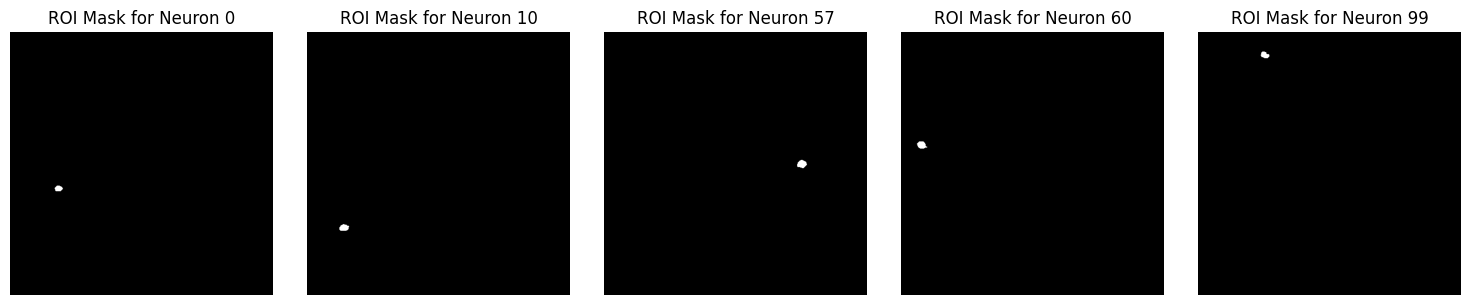

In [ ]:
# lets have a look at the ROI masks of the neurons
print("roi_masks shape: ", roi_masks.shape)
print("roi_masks max: ", np.max(roi_masks))  # Values are from 0 to 1

# lets plot the masks of some cells
cells = [0, 10, 57, 60, 99]
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i, cell in enumerate(cells):
    axs[i].imshow(roi_masks[cell], cmap="gray")
    axs[i].set_title(f"ROI Mask for Neuron {cell}")
    axs[i].axis("off")
plt.tight_layout()
plt.show()

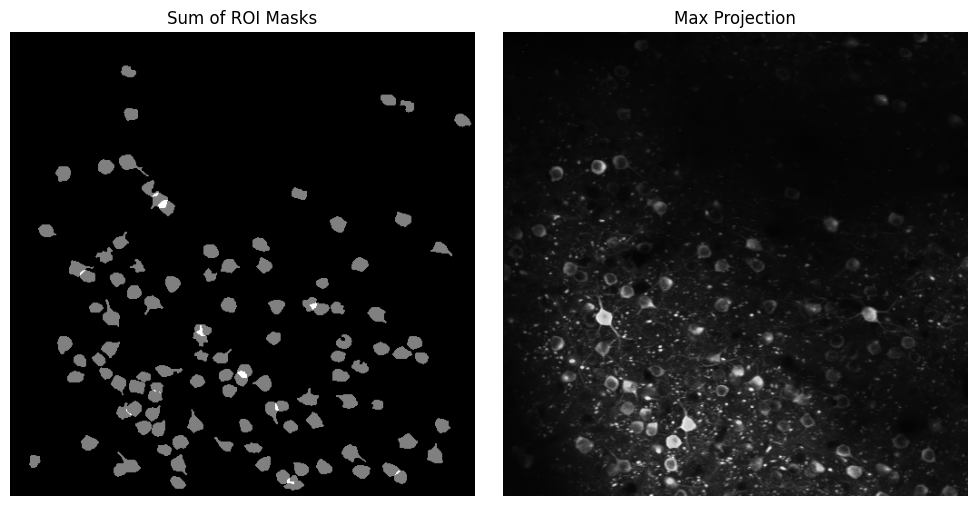

In [ ]:
# lets sum up the roi masks to get an overview of the neurons and compare it to the max projection
roi_masks_sum = np.sum(roi_masks, axis=0)
roi_masks_sum = roi_masks_sum / np.max(roi_masks_sum)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(roi_masks_sum, cmap="gray")
axs[0].set_title("Sum of ROI Masks")

axs[1].imshow(max_projection, cmap="gray")
axs[1].set_title("Max Projection")

for ax in axs:
    ax.axis("off")
plt.tight_layout()
plt.show()

# 2. Preprocessing

Generally, there are a few algorithms that can lead from a calcium trace signal to a discrete spike train. In the lecture, several algorithms were presented. The paper by Berens et al. (2018) from the lecture benchmarks these algorithms. The finding of this study is that the machine learning algorithm implemented shows the best results. We implemented this algorithm as well as the OOPSI and OASIS algorithms. The machine learning algorithm (c2s) showed a major underestimation of spikes towards the end. Therefore, even though it showed good results in the benchmark study, we decided not to follow up on it.

TODO: David/Steph wollen wir den c2s noch einmal hier beispielhaft darstellen bitte?

### 2.1 Process Data with OOPSI

First, we decided to process our data with the OOPSI algorithm (Vogelstein, 2009). This requires filtering. As we learned different filtering techniques in the lecture, we adapted them for this project. We implemented a Butterworth filter first, as a general bandpass filter. The bandwidth used was one-hundredth (low) and one-tenth (high) of the sampling frequency of approximately 30 Hz, divided by half of the sampling frequency. This was a reasonable bandwidth for similar settings. To increase the signal-to-noise ratio, we also implemented a Wiener filter. This was also done by the original OOPSI authors. The effect of the filters can be assessed with the plots below.

Then we applied the actual OOPSI deconvolution. The resulting spike train is shown below in a plot together with the OASIS spike trains.

In [ ]:
# butterworth filter
low = 0.3 / (fs / 2)
high = 3 / (fs / 2)

dff_butter = utils.butter_filter_signal(x=dff, low=low, high=high, fs=fs, order=4)

# wiener filter
window_wiener = 10
dff_wiener = utils.wiener_filter_signal(x=dff, window=window_wiener)

# both filters applied sequentially
dff_both = utils.wiener_filter_signal(x=dff_butter, window=window_wiener)

In [ ]:
interact(
    vis.update_filter_traces_plot,
    cellIdx=vis.cell_index_slider(value=10),
    sample_range=vis.time_interval_slider(value=[1634.0, 1812.0]),
    dff_butter=fixed(dff_butter),
    dff_wiener=fixed(dff_wiener),
    dff_both=fixed(dff_both),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Neuron Index:', layout=Layout(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
# apply OOPSI
# we provide the processed data as a file
if not from_file:
    oopsi_spikes = utils.oopsi_inference(
        dff=dff_both, dt=dt, thresh=0.035, to_file=False
    )
else:
    oopsi_spikes = utils.load_inferred_spikes("../data/inference_oopsi.pkl")

for k in oopsi_spikes.keys():
    print(f"Key: {k}, Shape: {oopsi_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


### 2.2 Process Data with OASIS

The OASIS algorithm also follows a deconvolution approach (Friedrich et al., 2017).

One of the main aspects in all three algorithms is that you don't get a binary spike train; instead, the spikes are continuous values between 0 and 1. This creates problems when you want to downsample the spikes to the stimulus frequency later on, as you then need a proper spike count. The returned spike train can be fed into the spike count, but this leads to an underestimation of the impact of the spikes. Therefore, the signal would need to be scaled to account for the underestimation. This leads to the question of what factor the scaling needs to be done. Also, non-binary spike trains make peri-stimulus time histograms and visual assessment of the spike trains much harder. In total, a binary spike train makes further analysis easier, even though you lose information about the certainty of the spikes. Since OASIS already implements a threshold approach for assessing whether or not we have an actual spike, the "noisy" spike train from OASIS can be directly translated to a binary spike train, which is what we did.

In [ ]:
# run OASIS or load the results
if not from_file:
    oasis_spikes = utils.oasis_inference(dff=dff, to_file=False)
else:
    oasis_spikes = utils.load_inferred_spikes("../data/inference_oasis.pkl")

for k in oasis_spikes.keys():
    print(f"Key: {k}, Shape: {oasis_spikes[k].shape}")

Key: spikes, Shape: (106, 115471)
Key: deconv, Shape: (106, 115471)
Key: binspikes, Shape: (106, 115471)


In [ ]:
# lets compare the inferred spikes of OOPSI and OASIS
interact(
    vis.update_inferred_spikes_plot,
    cellIdx=vis.cell_index_slider(value=10),
    sample_range=vis.time_interval_slider(value=[1634.0, 1812.0]),
    show_oopsi=vis.checkbox(value=True, description="Show OOPSI"),
    show_oasis=vis.checkbox(value=True, description="Show OASIS"),
    oopsi_spikes=fixed(oopsi_spikes),
    oasis_spikes=fixed(oasis_spikes),
    input_trace=fixed(dff_both),  # filtered input data for oopsi (oasis is raw data)
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Neuron Index:', layout=Layout(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

Looking at the default values in the exploratory plot, we can clearly see a difference between OOPSI and OASIS. Whilst OOPSI often reduces high signals to one spike, OASIS recognizes a lot of fast spikes happening. This might be due to restrictive filtering for OOPSI but could also indicate the better functionality of OASIS. Therefore, and because OASIS requires no filtering and applies direct thresholding, we opted for OASIS and chose to use the inferred binary spike train from OASIS for the rest of the analysis.

In [ ]:
# as we use OASIS spikes for the following analysis, this is referred to as inferred_spikes
inferred_spikes = oasis_spikes
print(inferred_spikes.keys())
vis.set_inferred_spikes(
    inferred_spikes
)  # set the inferred spikes for the visualization class

dict_keys(['spikes', 'deconv', 'binspikes'])


### 2.4 Processing with c2s

TODO

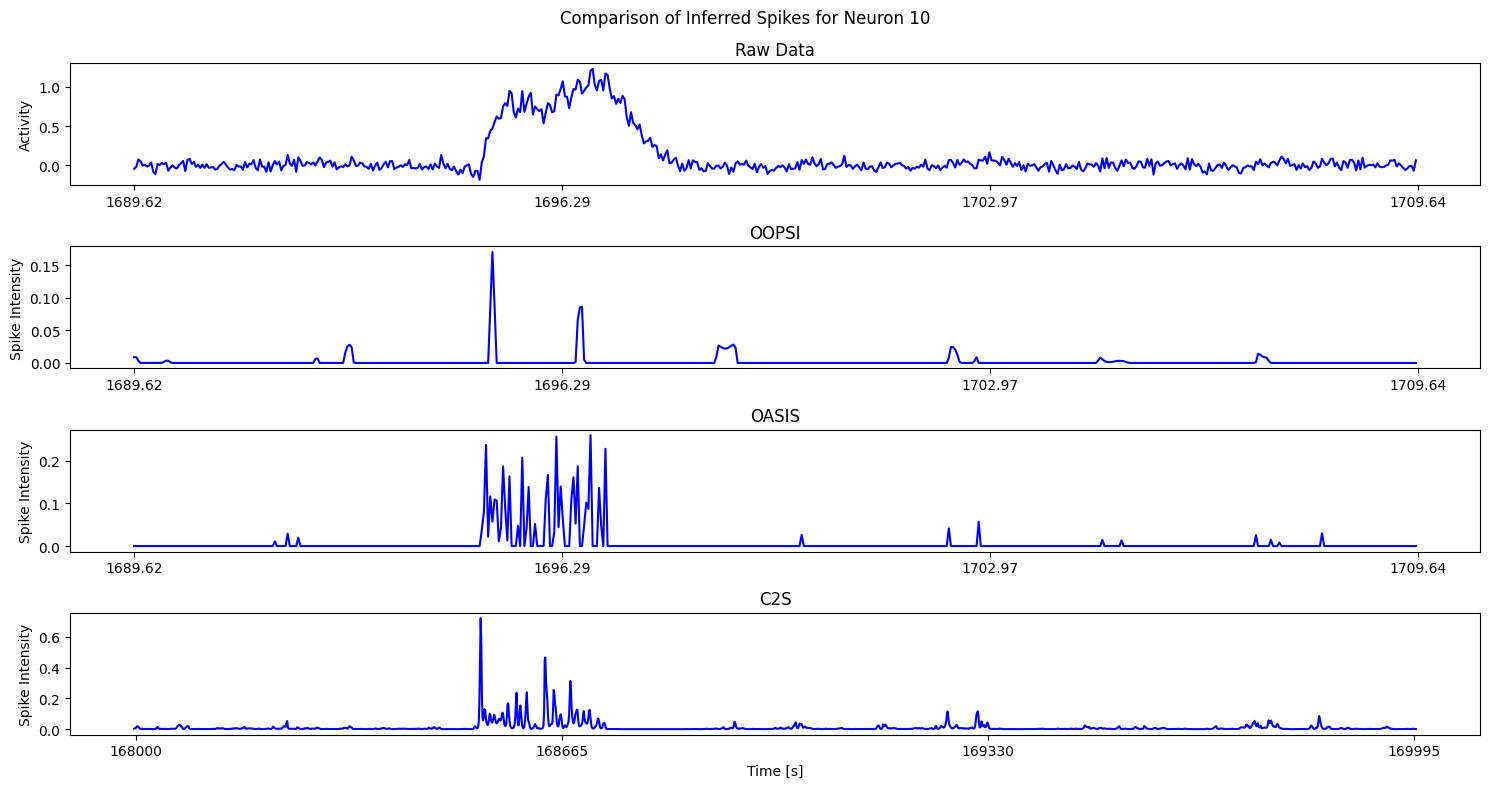

In [ ]:
# load c2s_c10_predicted.pkl from file

with open("../data/c2s_c10_predicted.pkl", "rb") as f:
    c2s_neuron_10 = pickle.load(f)[0]["predictions"][0]

start = int(1680 * fs)
end = int(1700 * fs)

# def plot_c2s_comparison(sample_range: float, )
fig, axs = plt.subplots(4, 1, figsize=(15, 8), tight_layout=True)
axs[0].plot(t[start:end], dff[10, start:end], "b")
axs[0].set_title("Raw Data")
axs[0].set_ylabel("Activity")

axs[1].plot(t[start:end], oopsi_spikes["spikes"][10, start:end], "b")
axs[1].set_title("OOPSI")
axs[1].set_ylabel("Spike Intensity")

axs[2].plot(t[start:end], oasis_spikes["spikes"][10, start:end], "b")
axs[2].set_title("OASIS")
axs[2].set_ylabel("Spike Intensity")
for i in range(3):
    axs[i].set_xticks(np.linspace(t[start], t[end], 4))

# translate time to c2s time, as it is upsampled to 100Hz
factor = c2s_neuron_10.size / t.size
c2s_start = int(start * factor)
c2s_end = int((end * factor))  # - (factor * 10))
axs[3].plot(
    np.arange(len(c2s_neuron_10))[c2s_start:c2s_end],
    c2s_neuron_10[c2s_start:c2s_end],
    "b",
)
axs[3].set_title("C2S")
axs[3].set_ylabel("Spike Intensity")
axs[3].set_xticks(np.arange(168000, 170000, 200 * factor))
axs[3].set_xlabel("Time [s]")

# timespan = np.linspace(t[start], t[end], 6)
# timespan_string = [f"{t:.2f}" for t in timespan]
# for ax in axs.flatten():
#     ax.set_xticklabels(timespan_string)

plt.suptitle("Comparison of Inferred Spikes for Neuron 10")
plt.show()

### 2.4 Visual Analysis of Filtered Spikes

Explicitly looking at the distribution of spikes for each neuron can help to understand how spikes react to the stimuli. To see the reaction to certain combinations of stimuli, we overlaid the spike trains for each distinct stimulus. Stimuli differ in their direction and the temporal frequency at which they are presented. With the "Spike Density Function," you can toggle peri-stimulus time histograms.

In [ ]:
interact(
    vis.update_stimulus_spike_times,
    cellIdx=vis.cell_index_slider(value=10),
    frequency=vis.frequency_dropdown(),
    histogram=vis.checkbox(value=False, description="Spike Density Function"),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Neuron Index:', layout=Layout(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

#### Neuron 105
In our visual analysis of the inferred spike trains, we noticed that neuron 105 has no more spikes after inference. Therefore, we declare this neuron as not sensitive to the grating stimulus and remove it from the data to prevent bias.

In [ ]:
dff = data["dff"][:-1, :].copy()
roi_masks = data["roi_masks"][:-1, :, :].copy()
inferred_spikes["spikes"] = inferred_spikes["spikes"][:-1, :].copy()
inferred_spikes["deconv"] = inferred_spikes["deconv"][:-1, :].copy()
inferred_spikes["binspikes"] = inferred_spikes["binspikes"][:-1, :].copy()

print(dff.shape, roi_masks.shape, inferred_spikes["spikes"].shape)
vis.remove_cell_105(dff, roi_masks, inferred_spikes)

(105, 115471) (105, 512, 512) (105, 115471)


## 2.4 Intermediate Analysis

### Running Speed
To assess whether running speed has an influence on our firing rate, we can visualize the data and look at the correlations of both measurements. One could argue that a higher running speed leads to higher arousal in the mouse and, therefore, to more spontaneous spiking activity. Therefore, it is important to consider the effects of running speed on our spike trains.

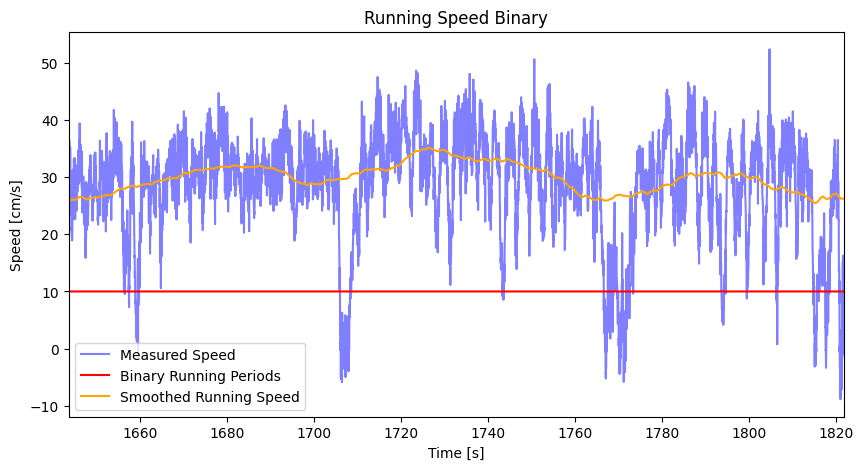

In [ ]:
# we filter the running speed signal
running_periods = utils.filter_running_speed(running_speed)
# convolution und smoothing mit root mean squared error
# Window size: we apply quite heavy smoothing for better visualization --> between 500-1000 is feasible here
running_smooth = utils.window_rms(running_speed, 750)

vis.filtered_running_speed(1634.0, 1812.0, running_periods, running_smooth)

Top 10 neurons with highest absolute correlation with running activity (descending order):
	Neuron	|Correlation|
1.	  24	  0.1865569
2.	  76	  0.0891345
3.	  77	  0.0884480
4.	  80	  0.0725633
5.	  93	  0.0672950
6.	  40	  0.0578098
7.	  55	  0.0559251
8.	  102	  0.0535339
9.	  78	  0.0523293
10.	  21	  0.0517158


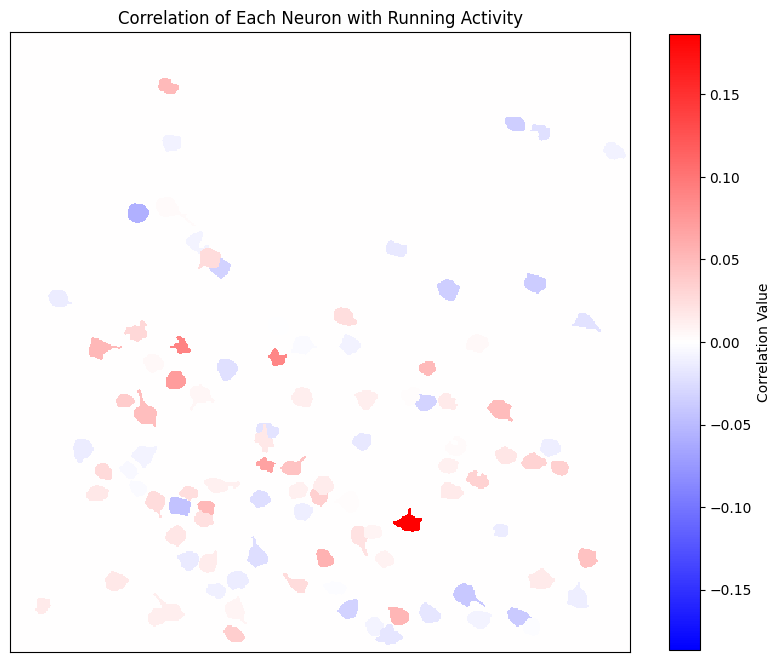

In [ ]:
# we calculate the correlation between the running speed and the inferred spikes per neuron
roi_corr, cell_corr, top_10 = utils.get_running_correlation_max(
    roi_masks, inferred_spikes["spikes"], running_speed
)

print(
    "Top 10 neurons with highest absolute correlation with running activity (descending order):"
)
print("\tNeuron\t|Correlation|")
for i, neuron in enumerate(top_10):
    print(f"{i+1}.\t  {neuron}\t  {np.abs(cell_corr[neuron]):.7f}")
vis.plot_cell_running_correlation(roi_corr)

We can see that, even though some neurons clearly have a higher correlation with running speed than others, the overall magnitude of the correlations is rather small. Therefore, as running speed seems to have no major effect on our spike trains overall, we can keep the neurons with a higher correlation with running speed in mind as potentially more noisy but won't need to take steps to filter out the effects of running speed.

# 3. Tuning Function and Statistical Analysis

To assess whether there is a spatial distribution in the orientation and direction preference and preference for spatial frequency, we need to compute the tuning function for each neuron and determine whether the neuron has a significant preference for direction, orientation, or both. To include spatial frequency in the computation, we examine the effect of temporal frequency on the preference of each neuron.

As a tuning function, we use the von Mises tuning function, which can account for a mixture of orientation and directional preferences by adding the first harmonic to the orientation fit. We analyze the tuning function fit for each temporal frequency separately. This approach was also used by Moore et al. (2005). They found that temporal frequency affected the directional preference of a neuron, while orientation preference was invariant to temporal frequency.

Therefore, by examining the temporal components separately, we might be able to replicate these findings with our data. We would be able to observe interaction effects between temporal frequency and directional preference.

## 3.1 Fitting von von Mises Tuning Curve

To fit the von Mises curve, we follow the steps from CL4. During the fit, we separate the spike counts by spatial frequency and fit each curve separately. The plot below shows that this leads to a very good fit in some neurons (10, 11, 19, 34, ...), while other neurons seem to have no preference for either direction or orientation.

You can also observe in some neurons that there seems to be an effect of temporal frequency on the fitting. For instance, such an effect is visible in neuron 23 (which seems to be orientation-tuned), neuron 55 (which seems to be direction-tuned for direction 0° and frequency 1 and 2 Hz), and neuron 4 (which seems to be direction-tuned for temporal frequency 15 Hz).

To determine whether there is a significant effect of temporal frequency on direction or orientation tuning, we first need to identify which neurons are significantly sensitive to direction or orientation.

In [ ]:
# Fit a von Mises tuning curve to the spike counts in count with direction dir using a least-squares fit.
fitted_tuning_curves = utils.fitTemporalTuningCurve(
    inferred_spikes,
    stim_table,
)

100%|██████████| 105/105 [00:12<00:00,  8.63it/s]


In [ ]:
# TODO description David was passiert da?
max_of_temporal_tuning_curve = utils.getMaxOfTemporalTuningCurves(
    fitted_tuning_curves.copy(), stim_table
)
max_of_temporal_tuning_curve[0]

{'max_direction': 90.0, 'max_direction2': 270.0, 'is_orientationnal': 1}

In [ ]:
interact(
    vis.update_directional_tuning_curve,
    cellIdx=vis.cell_index_slider(value=10),
    tuning_curve_fit=fixed(fitted_tuning_curves),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Neuron Index:', layout=Layout(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## 3.2 Statistical Analysis of the Tuning Curves

To determine which neurons are significantly tuned for orientation or direction, we examine the Fourier components for orientation and direction for each neuron. We then create a permutation of the spike counts and recalculate the Fourier components. This process generates a distribution that allows us to assess whether our original Fourier components fall within this distribution. The procedure and the math behind it follow CL4.

In [ ]:
# the permutation test for the tuning function is run in parallel, but it takes a while. We can load the results from file.
if not from_file:
    testTuningFunctionResultsOr, qdistr_Or = utils.testTuningFunction_opt(
        inferred_spikes, stim_table, psi=2
    )
    testTuningFunctionResultsDir, qdistr_Dir = utils.testTuningFunction_opt(
        inferred_spikes, stim_table, psi=1
    )
else:
    testTuningFunctionResultsOr, qdistr_Or = utils.load_tuning_test_results(
        orientation=True
    )
    testTuningFunctionResultsDir, qdistr_Dir = utils.load_tuning_test_results(
        orientation=False
    )
testTuningFunctionResultsOr[0].keys()

dict_keys([1, 2, 4, 8, 15, -1])

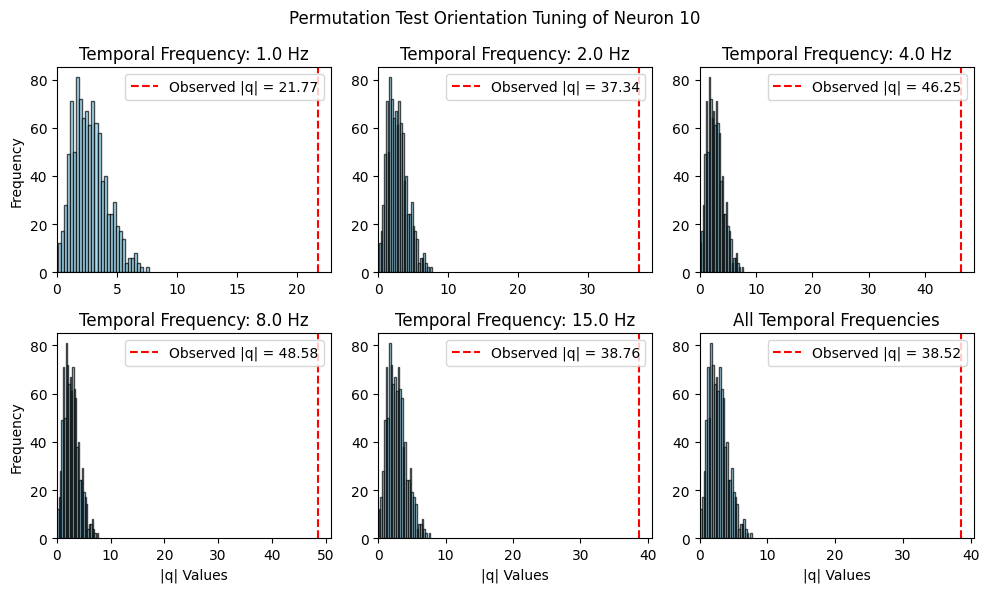

In [ ]:
vis.plot_tuning_orientation_test(10, testTuningFunctionResultsOr, qdistr_Or)

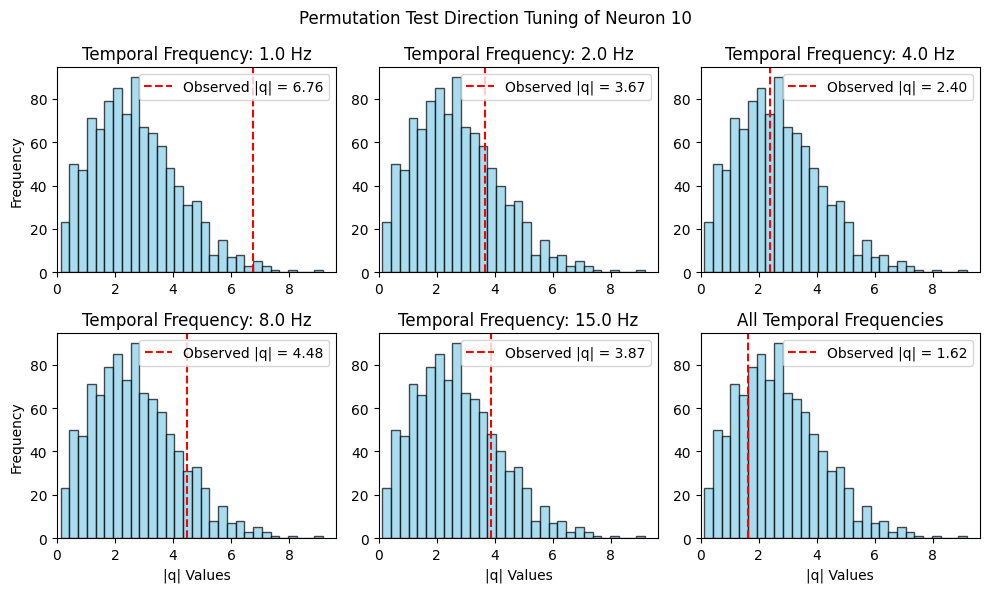

In [ ]:
vis.plot_tuning_orientation_test(
    10, testTuningFunctionResultsDir, qdistr_Dir, direction=True
)

In the plot, we can see the distributions for the orientation and direction Fourier components as a function of temporal frequency. In neurons that are clearly sensitive to the orientation of the stimulus, such as neurons 10, 11, or 19, we can observe that the spike count is highly dependent on the orientation of the stimulus. The magnitude of the Fourier component is much lower when the spike count is shuffled. This is exactly what we aimed to find.

### 3.3 Assessment of dependency of Temporal Frequency

To assess whether some neurons tend to have an increased firing rate at certain temporal frequencies, we plot the mean firing rate of each neuron at each temporal frequency. Since we do not need to model these firing rates, it is sufficient to determine whether there is a significant effect of temporal frequencies. This can be done using a non-parametric permutation test. For each neuron, we compute the difference in variance explained by the temporal frequency (using a one-way ANOVA) and compare it with 1000 permuted samples.

We can see that the firing rate of quite a few neurons is dependent on the temporal frequency at which the stimulus is presented.

In [ ]:
temporal_tunings = utils.getTemporalTunings(inferred_spikes, stim_table)

interact(
    vis.update_temporal_tuning_curve,
    cellIdx=vis.cell_index_slider(value=10),
    temporal_tunings=fixed(temporal_tunings),
)

interactive(children=(IntSlider(value=10, continuous_update=False, description='Neuron Index:', layout=Layout(…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [ ]:
def get_p_values_permutation_test(
    inferred_spikes, stim_table, n_permutations, load_from_file=False
):
    if load_from_file:
        neuron_stats, permuted_stats, p_values = pickle.load(
            open("../data/p_values_permutation_test.pkl", "rb")
        )
        return neuron_stats, permuted_stats, p_values
    else:
        neuron_stats, permuted_stats = utils.get_p_values_permutation_test_helper(
            inferred_spikes, stim_table, n_permutations
        )
        p_values = np.array(
            [
                np.mean(permuted_stats[neuron] >= neuron_stats[neuron])
                for neuron in range(inferred_spikes["binspikes"].shape[0])
            ]
        )
        pickle.dump(
            (neuron_stats, permuted_stats, p_values),
            open("../data/p_values_permutation_test.pkl", "wb"),
        )
        return neuron_stats, permuted_stats, p_values


neuron_stats, permuted_stats, p_values = get_p_values_permutation_test(
    inferred_spikes, stim_table, 10, from_file
)

In [ ]:
# extract the neurons which are significantly affected by the temporal frequency
temp_freq_affected_neurons = np.where(p_values < 0.001)[0]
temp_freq_affected_neurons

array([  2,   5,   6,   7,   8,  10,  12,  14,  17,  18,  20,  21,  23,
        24,  25,  26,  27,  28,  29,  31,  32,  34,  35,  41,  42,  43,
        45,  46,  48,  49,  50,  51,  52,  53,  54,  55,  61,  63,  64,
        66,  70,  71,  75,  77,  79,  80,  82,  84,  90,  93,  95,  99,
       100, 101, 102])

### 3.4 Complex vs Simple Cells:

Dividing simple cells and complex cells by the f1/f0 ratio (linearity index) is a well-known procedure, first noted by Hubel and Wiesel (1962; Journal of Physiology, London, 160, 106–154). Because this method has been verified many times, we use the same ratio to classify simple and complex cells. In the lecture, we learned that both complex and simple cells are sensitive to the orientation of a stimulus, but only simple cells are sensitive to the direction (the phase) of the stimulus. Therefore, instead of computing the f1 component separately, we can use the Fourier components already extracted during our permutation tests. In the permutation tests, we compute $v_k = \exp(\psi i \theta_k)$, where $\theta_k$​ is the $k$-th direction of motion in radians and $\psi \in 1,2$ is the Fourier component to test (1: direction, 2: orientation). The magnitude $|q|$ tells us how much power there is in the $\psi$-th Fourier component (credit to CL4).

If we set $\psi$ to 1, we extract the magnitude (amplitude) of the first Fourier component (f1). This can be used to calculate the ratio to decide whether a cell is simple or complex. f0 can be described by the mean spike count binned by stimulus duration (0.5 Hz).

In total, we can say that if $ \frac{f1}{f0} < 1$, we have a complex cell, and if $\frac{f1}{f0} > 1$, we have a simple cell. Since the cell should be invariant to direction tuning at all temporal frequencies, but we observe significantly different values for direction tuning depending on the temporal frequency, we assess whether a cell is complex or not by computing a linearity index for all temporal frequencies. If all of those indices are smaller than 1, we can safely say that we have a complex cell.

An alternative for computing the ratio for complex and simple cells would be to extract the first Fourier component based on the frequency that corresponds to the stimulus. Following Wypych et al. (2012), the f1 component is defined as "[the] component of the amplitude spectrum of the spike response at the temporal frequency of stimulation." This approach was implemented below but did not yield the expected results—all cells were classified as complex. This might be due to a faulty implementation.

In [ ]:
## -----------------------------------------------------------------
## Implementation of linearity index following Wypych et al., (2012)
## -----------------------------------------------------------------
from scipy.fft import fft

stimulus_frequency = 0.5  # 1 stimulus every 2s
neurons = inferred_spikes["binspikes"].shape[0]
spike_count = np.zeros((neurons, stim_table["orientation"].shape[0]))
p_direction = np.zeros(neurons)
f1_comp = np.zeros(neurons)
for neuron in range(neurons):
    counts = utils.bin_spike_counts(stim_table, inferred_spikes, neuron=neuron)
    spike_count[neuron, :] = counts
    # transform spike counts to fourier domain
    fft_result = fft(counts)
    freqs = np.fft.fftfreq(len(counts), d=(1.0 / stimulus_frequency))
    # Magnitude of DC component
    f0 = np.mean(counts)
    # Find the index of the frequency closest to the stimulus frequency
    f1_index = np.argmin(
        np.abs(
            freqs - stimulus_frequency
        )  # find index of the frequency that is closest to stimulus frequency
    )  # fundamental frequency, f1 is the LOWEST POSSIBLE frequency of vibration in the system.
    #  The F1 values reported here are the magnitudes of the first component (at stimulus temporal frequency) of the frequency spectra
    # Compute the magnitude (amplitude) of the first harmonic component (F1)
    f1 = np.abs(fft_result[f1_index])
    f1_comp[neuron] = f1 / f0

In [ ]:
keys_dict = {1: "1", 2: "2", 4: "4", 8: "8", 15: "15", -1: "-1"}
p_thresh = 0.0001

## Implementation of linearity index using the described approach is in utils.py
## Just computes the ratio of the direction fourier magnitude and mean firing rate

df_dir = utils.process_tuning_results(
    testTuningFunctionResultsDir,
    stim_table,
    inferred_spikes,
    max_of_temporal_tuning_curve,
    list(keys_dict.keys()),
    p_thresh,
)
(
    df_or,
    df_complex,
    df_non_complex,
    comp_or,
    noncomp_or,
    comp_dir,
    noncomp_dir,
) = utils.process_tuning_data(
    testTuningFunctionResultsOr,
    max_of_temporal_tuning_curve,
    df_dir,
    list(keys_dict.values()),
)

# 4. Further Statistical Analysis

### 4.1 Significant Cells for orientational and directional tuning

Note: All conclusions are made at a significance level of p=0.0001. Since we make conclusions at this significance level, all p-values are treated as binary values (either the neuron is significant for this condition or it isn't). We chose this restrictive significance level because we were very liberal with our spike threshold, as described above.

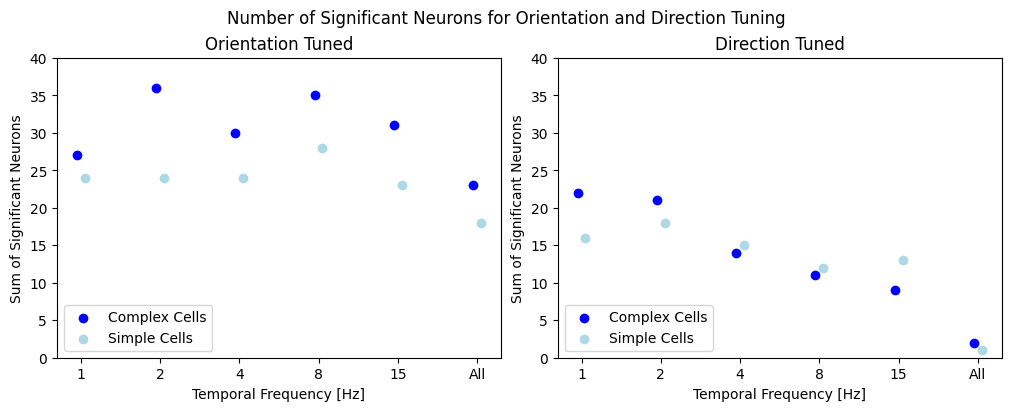

In [ ]:
vis.plot_num_significant_cells(comp_or, noncomp_or, comp_dir, noncomp_dir)

Overall, there are fewer neurons tuned for direction than there are tuned for orientation.

This plot shows a clear interaction between direction-tuned neurons and the temporal frequency of the stimulus presented. There are three neurons tuned for direction that are invariant to temporal frequency (one simple and two complex). However, there are many more neurons that are tuned for direction dependent on a specific temporal frequency. Therefore, we can conclude that the directional tuning component is always dependent on some temporal frequency at which the stimulus is presented, and the neurons react specifically to the combination of direction and temporal frequency.

There appears to be no interaction between the temporal component and orientation. There are equally many neurons sensitive to an orientation at a specific temporal frequency as there are at all temporal frequencies. It seems that the temporal component does not affect the neuron's preferred orientation—the neuron prefers the orientation (i.e., is tuned to it) regardless of the temporal frequency at which it is presented. This is reassuring because it implies a sanity check of our data; if it were dependent on the temporal frequency, the orientation component would not simply reflect orientation but would take more complex structures into account.

It is surprising that there are as many complex cells as there are simple cells tuned for direction. This should not be the case, as the linearity index (f1/f0) ratio should ensure that only neurons invariant to the phase of the grating—meaning invariant to direction and temporal frequency—are classified as complex. This implies that either there is substantial random noise in our data and the curves are falsely fitted to the direction, or that the f1/f0 ratio is either not correctly implemented or not conservative enough to account for random noise in our spike trains.


In [ ]:
# we perform a Kolmogorov-Smirnov test
utils.kolmogorovTest(df_or)
utils.kolmogorovTest(df_dir)
utils.kolmogorovTest(df_or, df_dir)

----------------------------------------------------
Significance Testing for Orientational Tuned Neurons
----------------------------------------------------
  Base Distribution Compared Distribution  KS Statistic   P-value
0          all_freq                  1_hz      0.152381  0.174932
1          all_freq                  2_hz      0.219048  0.012759
2          all_freq                  4_hz      0.171429  0.091348
3          all_freq                  8_hz      0.209524  0.019676
4          all_freq                 15_hz      0.142857  0.234976
----------------------------------------------------
----------------------------------------------------
Significance Testing for Orientational Tuned Neurons
----------------------------------------------------
  Base Distribution Compared Distribution  KS Statistic       P-value
0          all_freq                  1_hz      0.495238  4.664379e-12
1          all_freq                  2_hz      0.514286  5.117040e-13
2          all_freq    

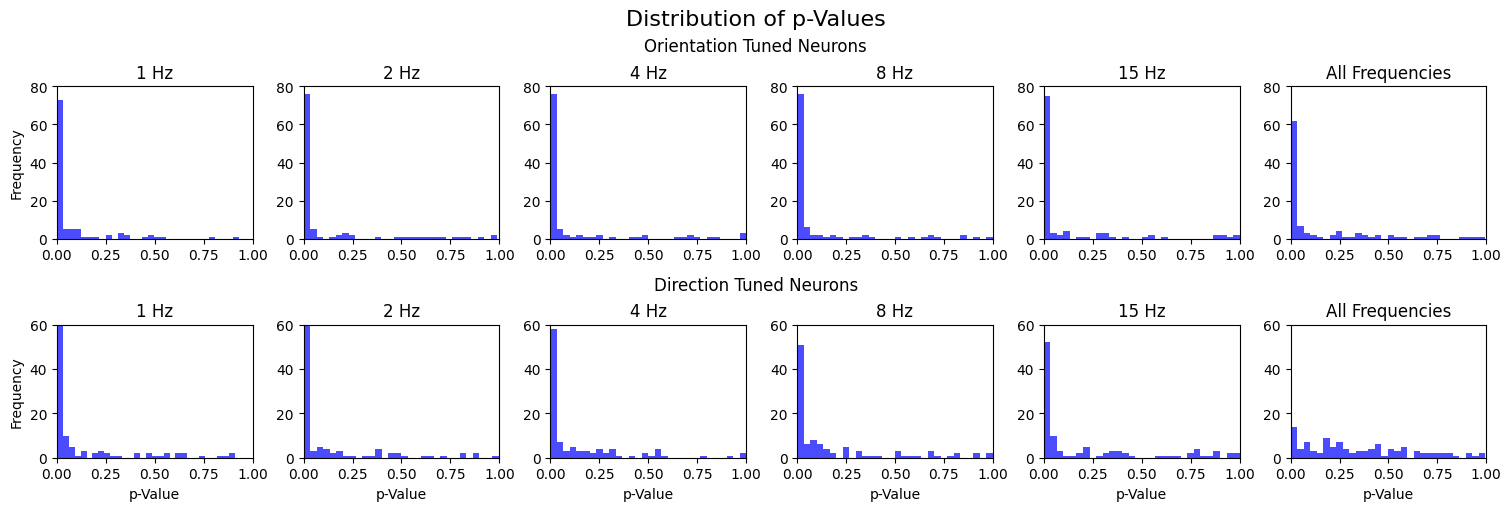

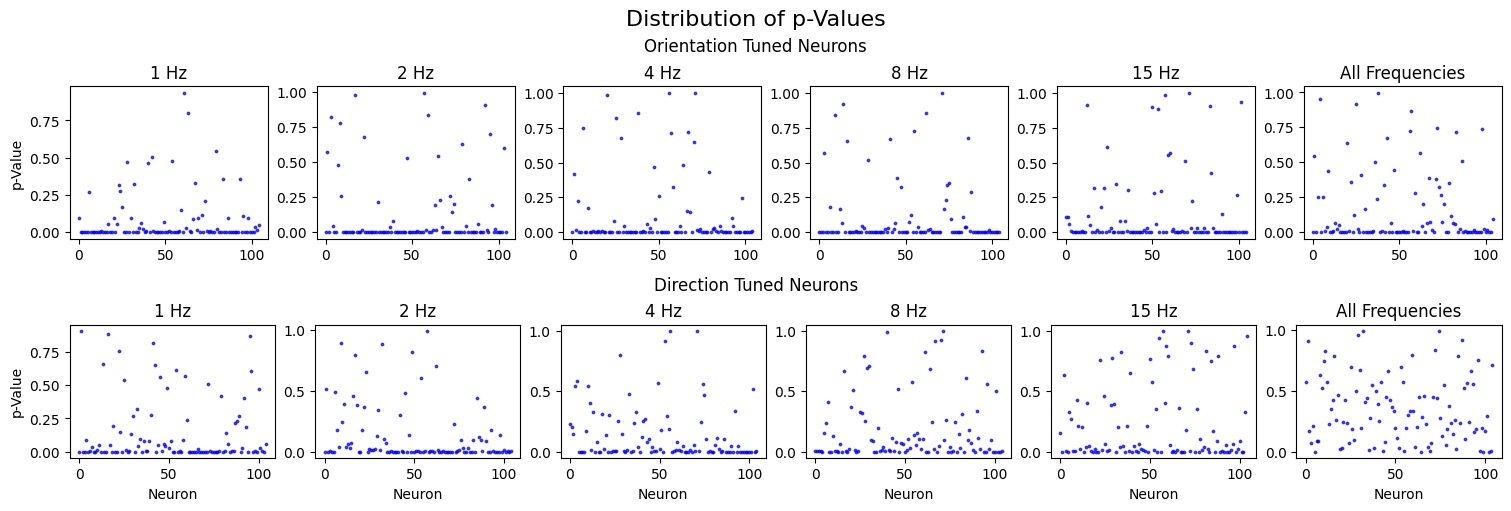

In [ ]:
vis.plot_p_distribution(df_or, df_dir, hist=True)
vis.plot_p_distribution(df_or, df_dir, hist=False)

Looking at the Kolmogorov-Smirnov statistic to assess the statistical difference between two distributions, the findings are consistent with what we inferred visually from the first plot. There is a significant difference between the directional tuning of the all_freq distribution and each of the temporal frequency distributions. Therefore we can safely say that different processes created the distributions. This indicates, as described above, an interaction effect between directional tuning and temporal frequency, which means that neurons are sensitive to a specific combination of temporal frequency and direction.

Additionally, we observe that the distributions of orientation and direction preferences do not come from the same source, as indicated by the significant statistic. This serves more as a sanity check for our data and doesn’t add new information, but it is reassuring to see that it corroborates our findings.

### 4.2 Spatial Structure of Tuning

Note: The task was to assess the spatial structure of orientation and direction-tuned neurons and the spatial structure of spatial frequency tuning. Given the direction and temporal frequency, we can infer the spatial frequency by combining these two pieces of information. This is addressed in the Direction Tuning part of the Conclusion, although it is not explicitly mentioned that we are referring to spatial frequency when discussing the interaction between direction and temporal frequency.

#### 4.2.1 Spatial structure of simple and complex cells
We observe no explicit spatial structure in the distribution of simple and complex cells. There appears to be some structure in the lower half of the ROI mask, with two clusters of complex cells and one cluster of simple cells. Overall, the random distribution makes sense from a biological perspective, as simple cells are typically connected to one or more complex cells. Therefore, it is logical that neither cell type is exclusively distributed to one side or half of our region of interest.

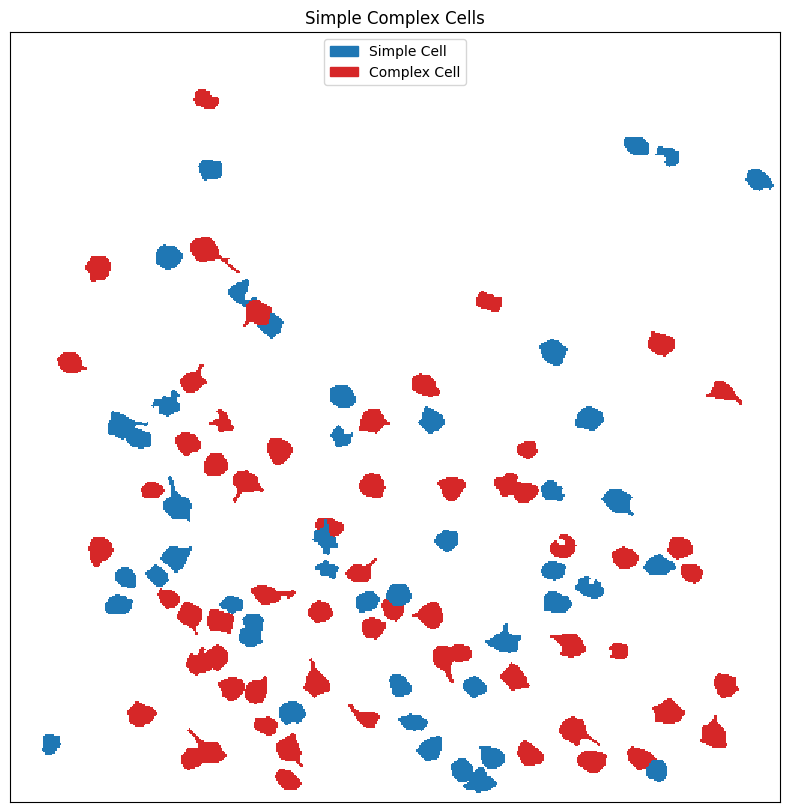

In [ ]:
vis.color_roi(df_dir["complex_flag"].values, "Simple Complex Cells", is_binary=True)

#### 4.2.2 Spatial Structure of the Direction Tuning

Since we observe a clear interaction between temporal frequency and direction tuning, we need to examine the individual temporal frequencies. We can only see a structure in the cells for a temporal frequency of 2 Hz, where we have the most significant direction-tuned neurons. The spatial structure of significantly direction-tuned neurons for all other temporal frequencies appears to be randomly distributed.

For a temporal frequency of 2 Hz, we see an increase in significant neurons in the upper left and lower middle to right areas of our region of interest. Interestingly, the neurons in the upper left corner are not significantly tuned for any of the other frequencies.

Upon closer examination of which neurons are significant for which temporal frequencies, we find that some neurons react to direction only at a specific temporal frequency. This means that some neurons tuned to movement are specifically tuned to movement at a certain frequency. Clusters of these neurons may arise due to coherent firing rates, meaning that the neurons fire at the same frequency and are therefore more likely to form a cluster.

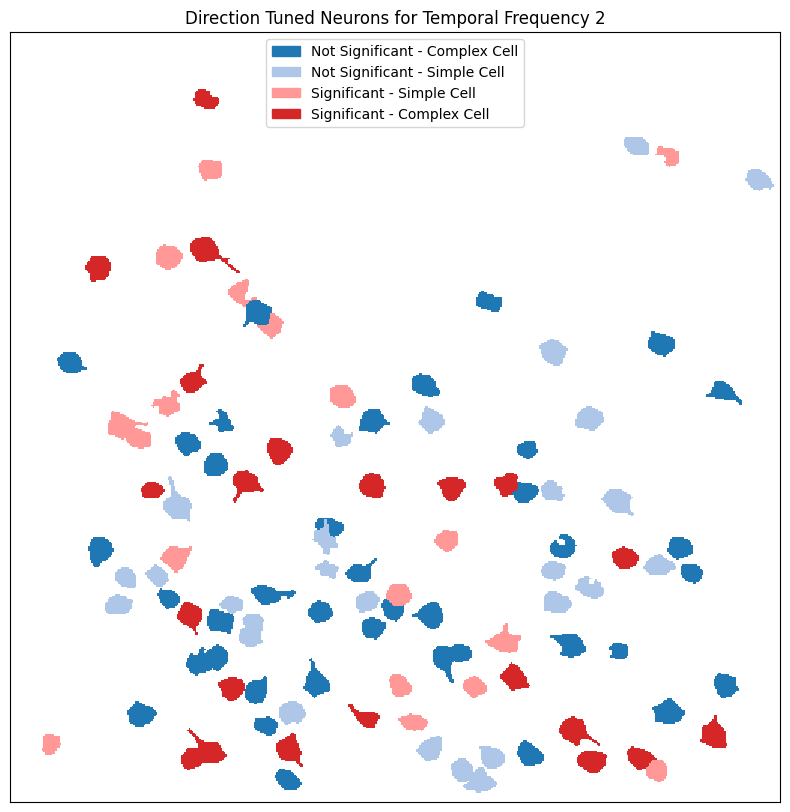

In [ ]:
data = np.zeros((2, len(df_dir["2"].values)))
data[0, :] = (df_dir["2"].values).astype(int)
data[1, :] = (df_dir["complex_flag"].values).astype(int)
vis.color_roi(data, "Direction Tuned Neurons for Temporal Frequency 2", is_binary=True)

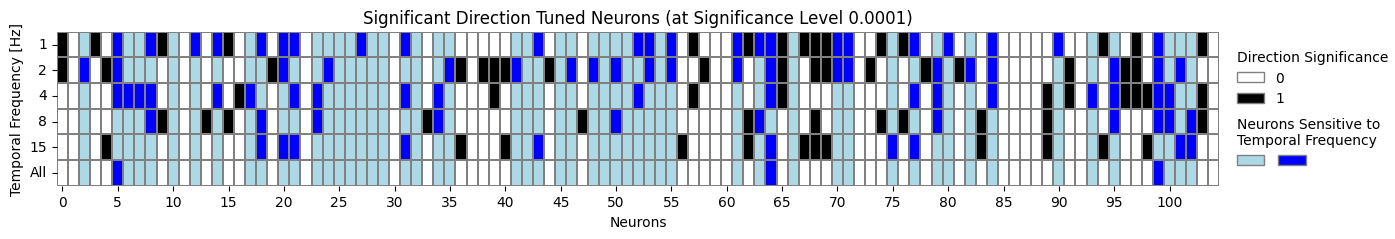

In [ ]:
vis.plot_significance_heatmap(
    df_dir, p_thresh, direction=True, temp_freq_idx=temp_freq_affected_neurons
)

You can also see that there are some neurons that prefer both 1 and 2 Hz, whilst others exclusively react to one frequency. This might either arise due to the similarity of 1 and 2 Hz compared to 4 and 8 Hz for instance, or it might be because some neurons prefer more than one frequency.

### TODO: Hier noch Text zur Erkenntnis der signifikanz der temporalen frequency einfügen 

#### 4.2.2 Spatial Structure of Orientation Tuned Neurons

As we can see, and as expected, there is no interaction between the temporal frequency at which a stimulus is preferred and the preferred orientation of that stimulus.

Overall, we observe little to no spatial structure in the distribution of orientation-tuned neurons. Ideally, we would expect or hope to see orientation-tuned simple cells located near orientation-tuned complex cells, suggesting that they might pass on information to the complex cells. We observe this in four instances. In one case, these cells also share the same preferred orientation.

We also notice that, in some cases though not all, cells that are close to each other are either both significant or both not significant. This either indicates that the cells were falsely separated, that they are influenced by neighboring cells, or that they actually have similar preferences. Determining which of these possibilities is correct would require further analysis.

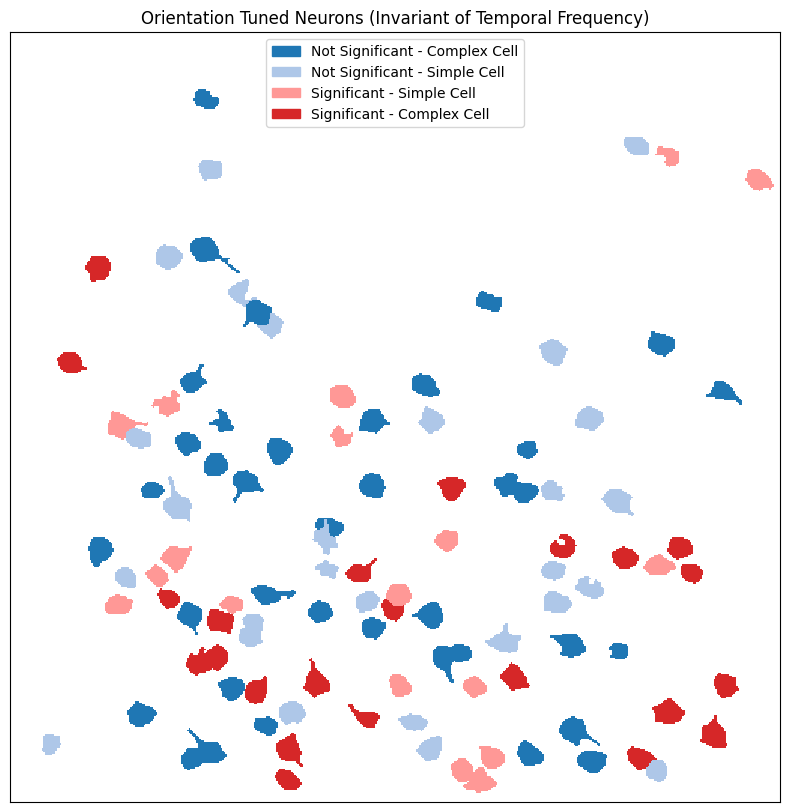

In [ ]:
data = np.zeros((2, len(df_or["-1"].values)))
data[0, :] = (df_or["-1"].values).astype(int)
data[1, :] = (df_or["complex"].values).astype(int)
vis.color_roi(
    data, "Orientation Tuned Neurons (Invariant of Temporal Frequency)", is_binary=True
)

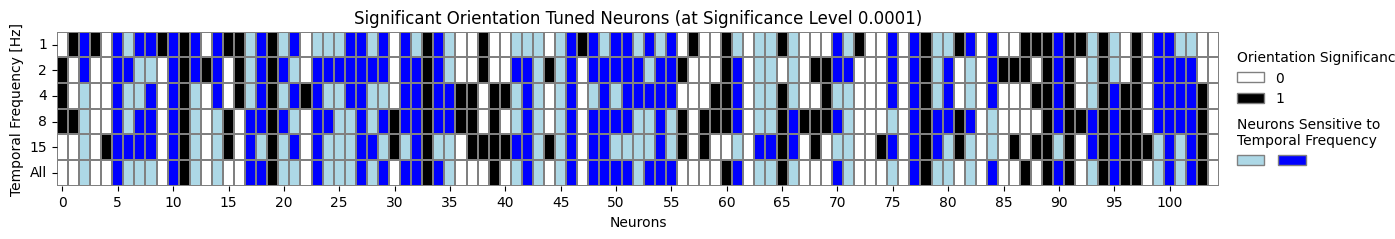

In [ ]:
vis.plot_significance_heatmap(
    df_or, p_thresh, direction=False, temp_freq_idx=temp_freq_affected_neurons
)

Interestingly, in the plot above, we observe that most neurons are significant at multiple temporal frequencies for orientation tuning. This further emphasizes that these neurons are invariant to the temporal frequency at which the stimuli are presented. Additionally, many neurons are significant across all temporal frequency conditions.

#### 4.2.4 Spatial Structure of the preferred Direction of each Neuron

We further investigated the spatial structure of the preferred direction/orientation of each neuron by extracting the two maximum peak values from each tuning function. Only direction- or orientation-sensitive (i.e., significant) neurons are plotted. The directions are color-coded; opposing directions share the same base color.

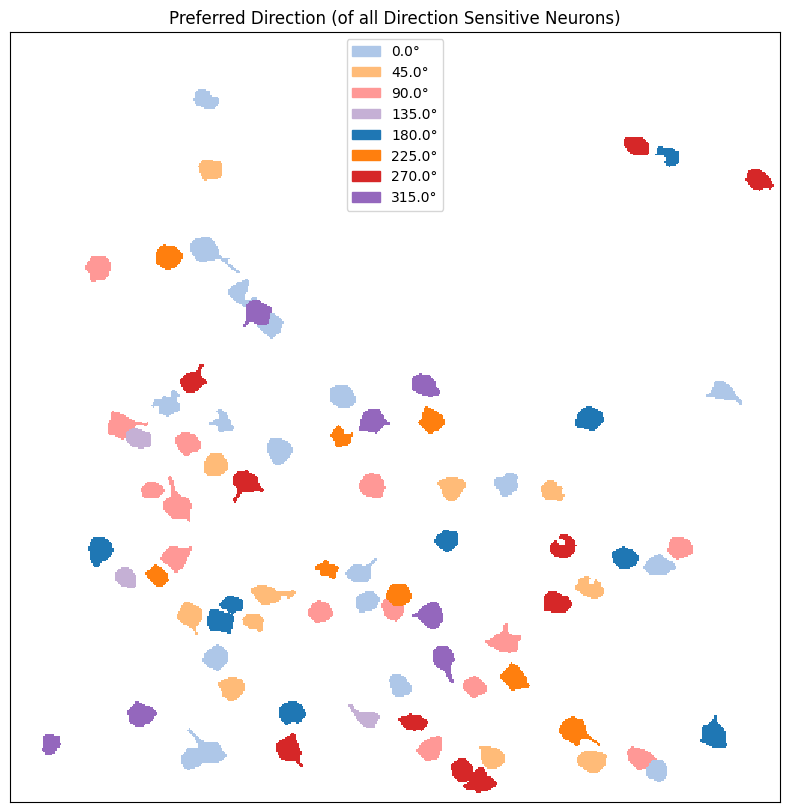

In [ ]:
keys_str = list(keys_dict.values())
sig_dir = [
    row["max_direction"] if (row[keys_str] == 1).any() else -1
    for index, row in df_dir.iterrows()
]
vis.color_roi(
    sig_dir,
    "Preferred Direction (of all Direction Sensitive Neurons)",
    is_binary=False,
)

We observe a tendency for neurons that prefer the same direction to be located in pairs; for example, if one neuron prefers 90°, there is likely another neuron very close by that also prefers 90°. However, this is a subjective assessment with no statistical backing.

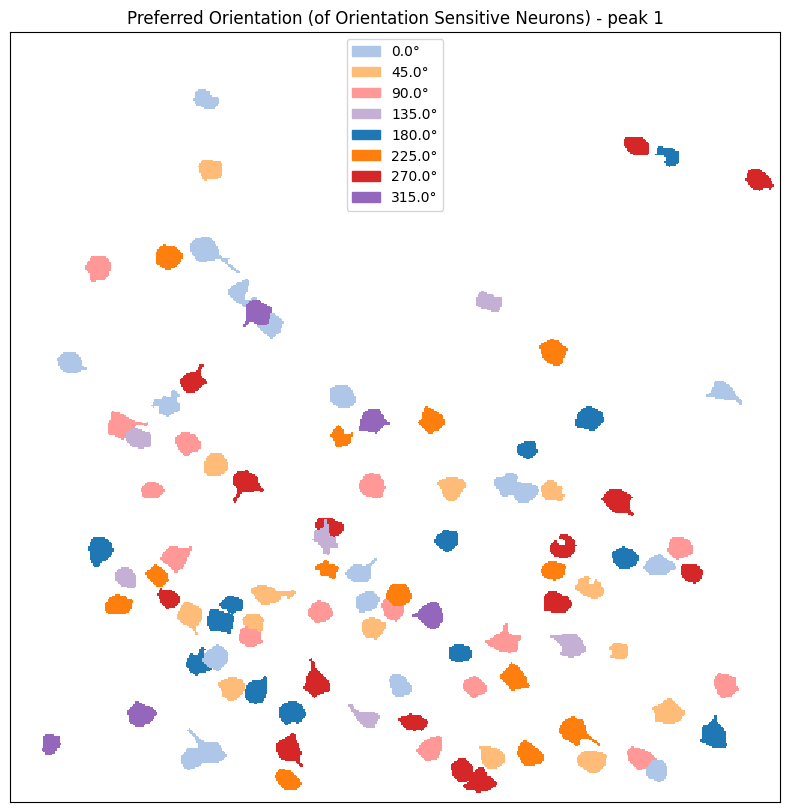

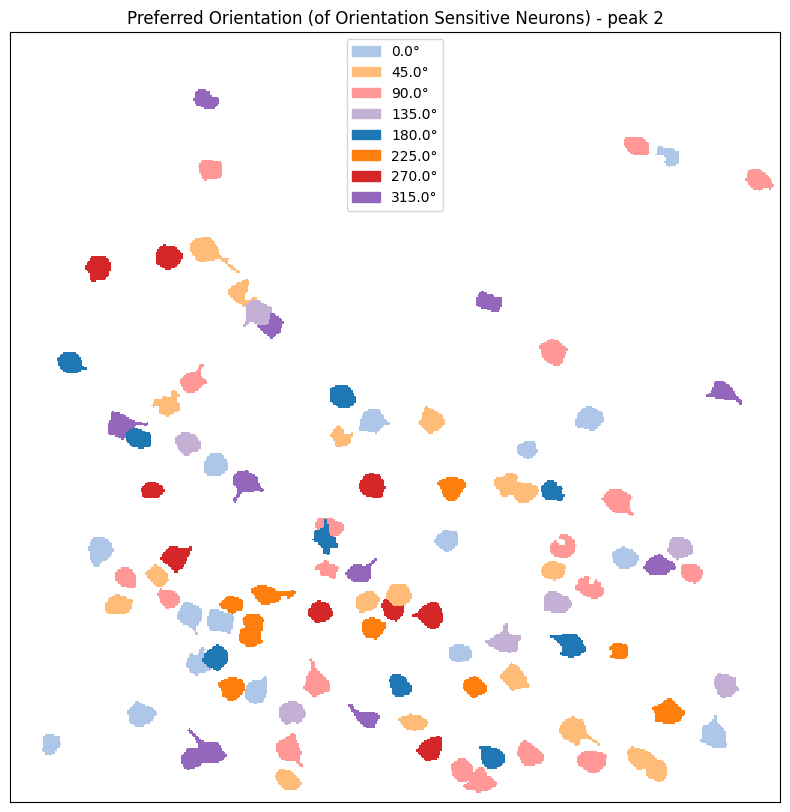

In [ ]:
sig_or = [
    row["max_direction"] if (row[keys_str] == 1).any() else -1
    for index, row in df_or.iterrows()
]
vis.color_roi(
    sig_or,
    "Preferred Orientation (of Orientation Sensitive Neurons) - peak 1",
    is_binary=False,
)
sig_or = [
    row["max_direction2"] if (row[keys_str] == 1).any() else -1
    for index, row in df_or.iterrows()
]
vis.color_roi(
    sig_or,
    "Preferred Orientation (of Orientation Sensitive Neurons) - peak 2",
    is_binary=False,
)

Since this plot shows neurons sensitive to orientation, opposing directions should be considered equivalent. This is also why we extracted the second maximum peak. Visually comparing these two plots, we see that the peaks often, though not always, correspond. Reflecting on the tuning functions, we note that peaks were not always clearly visible. This might indicate that our statistical inference is too sensitive and may also capture noisy neurons as significant for orientational tuning.

# 5. Conclusion

Overall, the most interesting finding is the interaction effect between preferred direction and temporal frequency. We also observe that the tuning for orientation and direction generally aligns with expectations. Many orientation-tuned neurons are significant and exhibit well-fitted tuning curve functions, as one would expect from a modeling perspective.

The main surprising finding is the presence of complex cells that are not invariant to the phase of the stimulus presented. This could indicate a faulty implementation, noisy data, or it might represent a novel finding. Further investigation is needed to determine the cause of this unexpected result.

Additionally, a statistical assessment of the spatial structure of the data could be considered to verify the trends discussed above.

In conclusion, this analysis provides an overview of the spike train data, but there may be additional information within the data that has yet to be discovered.

# Citations

Berens, P., Freeman, J., Deneux, T., Chenkov, N., McColgan, T., Speiser, A., ... & Bethge, M. (2018). Community-based benchmarking improves spike rate inference from two-photon calcium imaging data. PLoS computational biology, 14(5), e1006157.

Vogelstein, J. T. (2009). OOPSI: A family of optimal optical spike inference algorithms for inferring neural connectivity from population calcium imaging. The Johns Hopkins University.

Friedrich, J., Zhou, P., & Paninski, L. (2017). Fast online deconvolution of calcium imaging data. PLoS computational biology, 13(3), e1005423.

Moore IV, B. D., Alitto, H. J., & Usrey, W. M. (2005). Orientation tuning, but not direction selectivity, is invariant to temporal frequency in primary visual cortex. Journal of neurophysiology, 94(2), 1336-1345.

Wypych, M., Wang, C., Nagy, A., Benedek, G., Dreher, B., & Waleszczyk, W. J. (2012). Standardized F1–A consistent measure of strength of modulation of visual responses to sine-wave drifting gratings. Vision research, 72, 14-33.

Credit to the Lecture Neural Data Science and the corresponding coding labs, at lot of information was taken from there.

All texts were corrected (but not written) by ChatGPT.